<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/mlflow/summarization/T5_large_Finetune_multi_news_summarization_mlflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T5 finetuning for text Summarization

https://arxiv.org/pdf/1910.10683

https://huggingface.co/docs/transformers/model_doc/t5


- T5 is an encoder-decoder model pre-trained on a multi-task mixture of unsupervised and supervised tasks and for which each task is converted into a text-to-text format. T5 works well on a variety of tasks out-of-the-box by prepending a different prefix to the input corresponding to each task, e.g., for translation: translate English to German: …, for summarization: summarize: ….

- The pretraining includes both supervised and self-supervised training. Supervised training is conducted on downstream tasks provided by the GLUE and SuperGLUE benchmarks (converting them into text-to-text tasks as explained above).

- Self-supervised training uses corrupted tokens, by randomly removing 15% of the tokens and replacing them with individual sentinel tokens (if several consecutive tokens are marked for removal, the whole group is replaced with a single sentinel token). The input of the encoder is the corrupted sentence, the input of the decoder is the original sentence and the target is then the dropped out tokens delimited by their sentinel tokens.



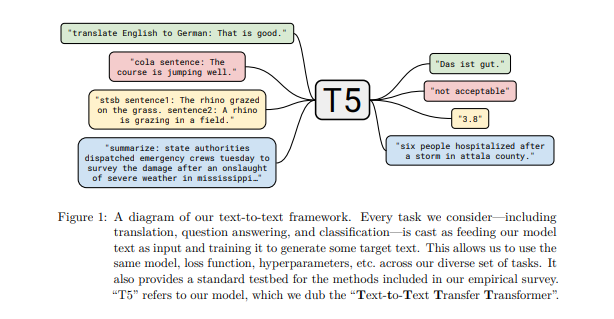

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! pip install mlflow pyngrok  --quiet
! pip install  evaluate  textstat tiktoken -q
! pip install psutil pynvml -q


In [ ]:
# Transformers installation
! pip install -q --disable-pip-version-check py7zr sentencepiece loralib peft trl
! pip install -q   bitsandbytes
! pip install datasets evaluate rouge_score -q
! pip install transformers[torch] -q
! pip install accelerate -U -q
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

In [ ]:
from google.colab import userdata
import os
MLFLOW_TRACKING_URI="databricks"
# Specify the workspace hostname and token
DATABRICKS_HOST="https://adb-2467347032368999.19.azuredatabricks.net/"
DATABRICKS_TOKEN=userdata.get('DATABRCKS_TTOKEN')

In [ ]:
if "MLFLOW_TRACKING_URI" not in os.environ:
    os.environ["MLFLOW_TRACKING_URI"] = MLFLOW_TRACKING_URI
if "DATABRICKS_HOST" not in os.environ:
    os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
if "DATABRICKS_TOKEN" not in os.environ:
    os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"]=userdata.get('KEY_OPENAI')

# Set Mlflow parameters

In [ ]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
mlflow.set_experiment("/Users/pepe@kk.com/summarization_fine_tuning")

mlflow.enable_system_metrics_logging()

In [ ]:

import argparse
import bitsandbytes as bnb
from datasets import load_dataset
from functools import partial
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, AutoPeftModelForCausalLM
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed, Trainer, TrainingArguments, BitsAndBytesConfig, \
    DataCollatorForLanguageModeling, Trainer, TrainingArguments
from datasets import load_dataset
from torch import cuda, bfloat16
import transformers
import locale
import torch
import torch.nn as nn
from google.colab import userdata
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:

from google.colab import output
output.enable_custom_widget_manager()

from transformers.utils import logging

logging.set_verbosity_warning()

os.environ["TRANSFORMERS_VERBOSITY"] = "warning"

In [ ]:


device = f'cuda:{cuda.current_device()}' if cuda.is_available() else 'cpu'
device


# Load multi_news dataset
https://huggingface.co/datasets/multi_news

In [ ]:
from datasets import load_dataset

dataset  = load_dataset("multi_news", trust_remote_code=True)

In [ ]:
dataset

In [ ]:

print(f"Train dataset size: {len(dataset['train'])}")
print(f"test dataset size: {len(dataset['test'])}")
print(f"Validation dataset size: {len(dataset['validation'])}")

In [ ]:
dataset['train'][100]['document']

In [ ]:
dataset['train'][100]['summary']

In [ ]:

len(dataset['train'][100]['document'])

In [ ]:
train = dataset['train'].to_pandas()

In [ ]:
def get_length(text):
  return len(text)

In [ ]:
train['length_document'] = train['document'].apply(get_length)
train['length_summary'] = train['summary'].apply(get_length)

In [ ]:
train['length_document'].max() /5, train['length_summary'].max() /5 # we consider a token 5 chars more or less

In [ ]:
train['length_document'].min() /5, train['length_summary'].min() /5 # we consider a token 5 chars more or less

In [ ]:
train['length_document'].mean() /5, train['length_summary'].mean() /5 # we consider a token 5 chars more or less

In [ ]:

len(dataset['train'][100]['summary'])

# There are two fields that you'll want to use:

- text: the text of the bill which'll be the input to the model.
- summary: a condensed version of text which'll be the model target.
# Preprocess
The next step is to load a T5 tokenizer to process text and summary:

Model--> https://huggingface.co/google-t5/t5-large

In [ ]:
from transformers import AutoTokenizer

PROJECT = "T5-large-Summarization"
MODEL_NAME = "google-t5/t5-large"
DATASET = "multi_news"
checkpoint = model_id = MODEL_NAME
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Preprocessing function:

- Prefix the input with a prompt so T5 knows this is a summarization task. Some models capable of multiple NLP tasks require prompting for specific tasks.
- Use the keyword text_target argument when tokenizing labels.
- Truncate sequences to be no longer than the maximum length set by the max_length parameter.

In [ ]:
prefix = "summarize: "


def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Tokenize dataset

In [ ]:

tokenized_dataset = dataset.map(preprocess_function, batched=True)

In [ ]:
tokenized_dataset

In [ ]:

len(tokenized_dataset['train'][100]['labels']), len(tokenized_dataset['train'][100]['input_ids'])


In [ ]:
tokenized_dataset['train'][100]['labels'][:10]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer


# load model from the hub
model = AutoModelForSeq2SeqLM.from_pretrained(model_id, torch_dtype=torch.bfloat16)

In [ ]:
def print_number_of_trainable_model_parameters(model, tag="original_model", to_wandb=False):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()

    if to_wandb:
      print({f'{tag}': {"trainable_model_params":trainable_model_params}})
      print({f'{tag}': {"all_model_params":all_model_params}})
      print({f'{tag}': {"percentage_of_trainable_model_parameters": 100 * trainable_model_params}} )

    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params}%"

In [ ]:
print_number_of_trainable_model_parameters(model, to_wandb=True)

In [ ]:
repository_id = f"{checkpoint.split('/')[1]}-{DATASET}"
repository_id

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

# Evaluate
https://huggingface.co/docs/evaluate/index

### ROUGE-N
ROUGE-N measures the number of matching n-grams between the model-generated text and a human-produced reference.


### ROUGE-1
Using R and C, we are going to compute the precision, recall, and F1-score of the matching n-grams. Let’s start computing ROUGE-1 by considering 1-grams only.


### ROUGE-L
ROUGE-L is based on the longest common subsequence (LCS) between our model output and reference, i.e. the longest sequence of words (not necessarily consecutive, but still in order) that is shared between both. A longer shared sequence should indicate more similarity between the two sequences.

### ROUGE-S
ROUGE-S allows us to add a degree of leniency to the n-gram matching performed with ROUGE-N and ROUGE-L. ROUGE-S is a skip-gram concurrence metric: this allows to search for consecutive words from the reference text that appear in the model output but are separated by one-or-more other words.


In [ ]:
import evaluate

rouge = evaluate.load("rouge")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load T5 with [AutoModelForSeq2SeqLM](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSeq2SeqLM):


At this point, only three steps remain:

1. Define your training hyperparameters in [Seq2SeqTrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainingArguments). The only required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the ROUGE metric and save the training checkpoint.
2. Pass the training arguments to [Seq2SeqTrainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Seq2SeqTrainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [ ]:
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
dataset_id = "multi_news"
# Hugging Face repository id
repository_id = f"{checkpoint.split('/')[1]}-{DATASET}"

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,

    learning_rate=2e-5,
    per_device_train_batch_size=6,
    per_device_eval_batch_size=6,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=4,
    predict_with_generate=True,
    fp16=False, #change to bf16=True for XPU
    bf16=True,
    logging_dir=f"{repository_id}/logs",
# Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=3000,
    save_strategy="steps",
    save_steps=3000,
    logging_steps=500,
    load_best_model_at_end=True,
    report_to="mlflow",
)



In [ ]:
PATH ="/content/drive/MyDrive/MODELS"

In [ ]:
!rm -rf /content/drive/MyDrive/MODELS/flan-T5-fine-tune

In [ ]:
!mkdir /content/drive/MyDrive/MODELS/flan-T5-fine-tune
custom_path = "/content/drive/MyDrive/MODELS/flan-T5-fine-tune"

In [ ]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    processing_class=tokenizer,

)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
model.generation_config.max_new_tokens = 128 # generate exactly 128 tokens when predicting
model.generation_config.min_new_tokens = 128

In [ ]:
import datetime
now = datetime.datetime.now()
now.strftime("%Y-%m-%d_%H:%M:%S")

# Pipelines / Tasks Types
https://huggingface.co/docs/transformers/en/main_classes/pipelines

In [ ]:
now = datetime.datetime.now()


with mlflow.start_run(run_name=f"fine_tune_model_{now.strftime('%Y-%m-%d_%H:%M:%S')}") as run:
    train_results = trainer.train()
    print(train_results.metrics)
    trainer.model.save_pretrained(custom_path)
    trainer.data_collator.tokenizer.save_pretrained(custom_path)

    transformers_model = {"model": trainer.model, "tokenizer": trainer.data_collator.tokenizer}
    task = "summarization"
    model_info = mlflow.transformers.log_model(
        transformers_model=transformers_model,
        artifact_path="text_summarizer",
        task=task,
    )
print(model_info.metadata)

In [ ]:
run.to_dictionary()


In [ ]:
run.data

In [ ]:
import transformers
from mlflow.models import infer_signature
from mlflow.transformers import generate_signature_output
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
model_info.artifact_path


In [ ]:
 model_info.model_uri

In [ ]:
summarization_components = mlflow.transformers.load_model(
    model_info.model_uri, return_type="components"
)

In [ ]:
summarization_components.keys()

In [ ]:
import torch
from tqdm.auto import tqdm

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:

! pip install  evaluate  textstat  -q

In [ ]:
reconstructed_pipeline = transformers.pipeline(**summarization_components)

In [ ]:
test1= dataset['test'][100]['document']

In [ ]:
output =reconstructed_pipeline(test1)

In [ ]:
import pprint
pprint.pprint(output[0]['summary_text'])

In [ ]:
dataset['test'][100].keys()

In [ ]:
df_test = dataset['validation'].to_pandas()

In [ ]:
df_test.columns = ['inputs', 'summary']

In [ ]:
df_test.head()

In [ ]:
import gc
import torch
torch.cuda.empty_cache()
gc.collect()

In [ ]:
now = datetime.datetime.now()


with mlflow.start_run(run_name=f"evaluate_fine_tune_model_{now.strftime('%Y-%m-%d_%H:%M:%S')}") as run:


    results = mlflow.evaluate(
        model_info.model_uri,
         df_test[:10],
        targets="summary",  # specify which column corresponds to the expected output
        model_type="text-summarization",  # model type indicates which metrics are relevant for this task
        evaluators="default",
    )


In [ ]:
import pprint
pprint.pprint(results.metrics)